# Ground-State: Heisenberg model


O objetivo deste código é aplicar arquitetura de redes neural (Boltzmann Machine) a fim de determinar o estado fundamental de um modelo de spin paradigmático: a cadeia antiferromagnética de Heisenberg com spin 1/2.

O hamiltoniano que consideraremos neste tutorial é o seguinte:

$$ H = \sum_{i=1}^{L} \vec{\sigma}_{i} \cdot \vec{\sigma}_{i+1}.$$

$L$ é o comprimento da cadeia, e usaremos condições de contorno abertas e periódicas. $\vec{\sigma}=(\sigma^x,\sigma^y,\sigma^z)$ denota o vetor de matrizes de Pauli.

ref: https://github.com/netket/netket

In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
# Import netket library
import netket as nk

# Import Json, this will be needed to load log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

## 1. Defining the Hamiltonian

In [3]:
# Define a 1d chain
L = 22
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

In [4]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)

In [5]:
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)

## 2. Exact Diagonalization (as a testbed)


In [6]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

# Just in case you can't do this calculation, here is the result
# exact_gs_energy = -39.14752260706246

The exact ground-state energy is E0= -39.147522607062776


## 3. The Jastrow ansatz

Aplicando um ansatz simples para o estado fundamental: o Ansatz de Jastrow.

$ \log\psi(\sigma) = \sum_i a_i \sigma_i + \sum_{i,j} \sigma_i J_{i,j} \sigma_j $


In [7]:
from flax import nnx
import jax.numpy as jnp
import jax

class Jastrow(nnx.Module):
    def __init__(self, N: int, *, rngs: nnx.Rngs):
        k1, k2 = jax.random.split(rngs.params())
        self.J = nnx.Param(0.01 * jax.random.normal(k1, (N, N),
                                                    dtype=jnp.complex128))

        self.v_bias = nnx.Param(0.01 * jax.random.normal(k2, (N, 1),
                                                         dtype=jnp.complex128))

    def __call__(self, x):
        x = x.astype(jnp.complex128)              # keep the dtypes aligned
        quad = jnp.einsum('...i,ij,...j->...', x, self.J, x)
        lin  = jnp.squeeze(x @ self.v_bias, -1)   # (...,N) @ (N,1) → (...,1)
        return quad + lin

Now that the model is defined, we can instantiate it

In [8]:
ma = Jastrow(N=hi.size, rngs=nnx.Rngs(0))
print(ma)

Jastrow()


In [11]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(300, out='Jastrow')
end = time.time()

print('### Jastrow calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',end-start,'seconds')

  0%|                                                                                                         …

### Jastrow calculation
Has 506 parameters
The Jastrow calculation took 14.687036991119385 seconds


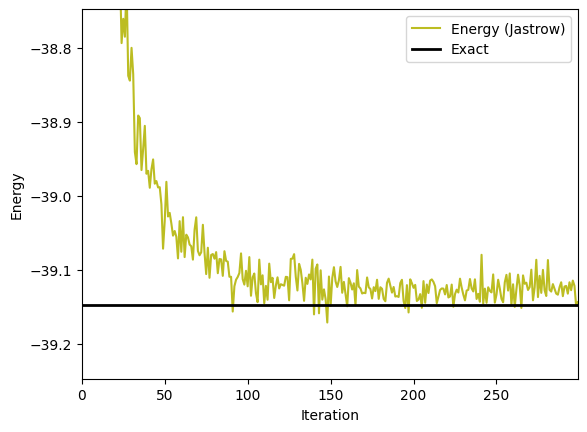

In [12]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))
   
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

## 3. Restricted Boltzmann Machine (RBM)

Vamos a Máquina de Boltzmann Restrita (RBM). Ela consiste simplesmente em duas camadas: uma visível, representando o spin $L$ de 1/2 grau de liberdade, e uma oculta, que contém um número diferente $M$ de unidades ocultas. Existem conexões entre todos os nós visíveis e ocultos. 

$\Psi_{\rm RBM} (\sigma_1^z,\sigma_2^z, ..., \sigma_L^z) = \exp ( \sum_{i=1}^L a_i \sigma_i^z ) \prod_{i=1}^M \cosh (b_i + \sum_j W_{ij} \sigma^z_j)$

$a_i$ (resp. $b_i$) são os biases visíveis (resp. ocultos). Juntamente com os pesos $W_{ij}$, eles são parâmetros variacionais que otimizaremos para minimizar a energia. 

Vamos definir a densidade de unidade oculta $\alpha = M / L$ e invocar o ansatz RBM no NetKet com tantas unidades ocultas quanto visíveis.

In [13]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)

In [15]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=600)
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

  0%|                                                                                                         …

### RBM calculation
Has 528 parameters
The RBM calculation took 23.886502027511597 seconds


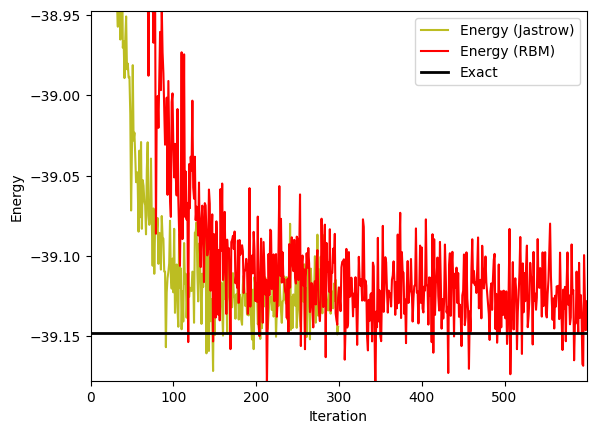

In [16]:
# import the data from log file
data=json.load(open("RBM.log"))
   
# Extract the relevant information
iters_RBM = data["Energy"]["iters"]
energy_RBM = data["Energy"]["Mean"]
    
fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

Observe que este gráfico se aproxima da energia exata do estado fundamental. Com 600 iterações, começamos a ver convergência e alcançamos a energia do estado fundamental com uma margem de erro de cerca de um por mil. Ao trabalhar com esses parâmetros, esperamos ter chegado a um resultado melhor, mas provavelmente com um custo maior de tempo de CPU. 

## 4. RBM novamente, desta vez com simetrias de rede

Vamos definir uma máquina RBM semelhante, que leve em consideração que o modelo possui simetrias translacionais. Todos os sítios são equivalentes e, portanto, muitos dos coeficientes das funções de onda estão relacionados por simetria. Usamos exatamente os mesmos hiperparâmetros do cálculo RBM anterior ($\alpha=1$, mesma taxa de aprendizado e número de amostras e iterações no Monte Carlo Variacional) e agora executamos uma RBM simétrica.

In [17]:
## Symmetric RBM Spin Machine
ma = nk.models.RBMSymm(symmetries=g.translation_group(), alpha=1)

# Metropolis Exchange Sampling
# Notice that this sampler exchanges two neighboring sites
# thus preservers the total magnetization
sa = nk.sampler.MetropolisExchange(hi, graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBMSymmetric', n_iter=300)
end = time.time()

print('### Symmetric RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The Symmetric RBM calculation took',end-start,'seconds')

  0%|                                                                                                         …

### Symmetric RBM calculation
Has 24 parameters
The Symmetric RBM calculation took 13.940536260604858 seconds


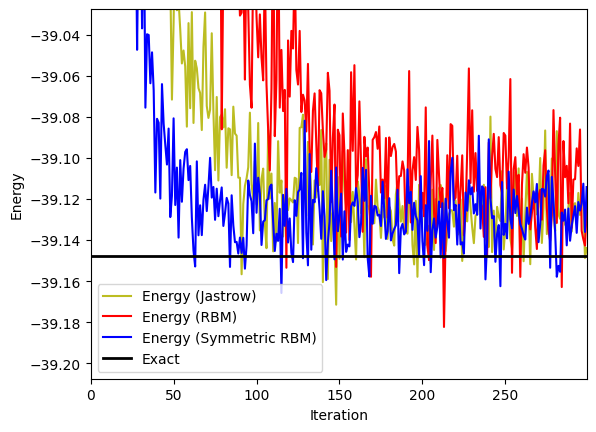

In [18]:
## import the data from log file
data=json.load(open("RBMSymmetric.log"))

# Extract the relevant information
iters_symRBM = data["Energy"]["iters"]
energy_symRBM = data["Energy"]["Mean"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
ax1.plot(iters_symRBM, energy_symRBM, color='blue', label='Energy (Symmetric RBM)')

ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
if exact_gs_energy:
    plt.axis([0,iters_symRBM[-1],exact_gs_energy-0.06,exact_gs_energy+0.12])
    plt.axhline(y=exact_gs_energy, xmin=0,
                    xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

Não só a simulação foi mais rápida em termos de tempo de CPU, como agora estamos alcançando o estado fundamental em um número muito menor de iterações.